In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import random
# set experiment consistency
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load data from the text file
with open('./data/IBM.txt', 'r') as file:
    lines = file.readlines()
    data = []
    dates = []

    for line in lines[1:]:
        parts = line.strip().split(',')
        date = parts[0]
        if '1980-12-12' <= date <= '2022-07-22':
            dates.append(date)
            data.append(float(parts[4]))  # 'Close' column

# Create a DataFrame from the loaded data
df = pd.DataFrame({'Date': pd.to_datetime(dates), 'Value': data})

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Extract the values from the DataFrame
signal = df['Value'].values
signal = signal.reshape(-1, 1)

# Define the training and testing data
train_size = int(len(signal) * 0.8)
train_data = signal[:train_size, :]
test_data = signal[train_size:, :]

# normalization
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

def create_groups(dataset, window_size_1, window_size_2, window_size_3, timeslice, step):
    X_data, y_data = [], []
    index = 0
    while index + (timeslice * window_size_3) < len(dataset):
        i = 0
        t1, t2, t3 = [], [], []
        l1, l2, l3 = [], [], []
        while i < timeslice* window_size_1:
            current_slice = dataset[index + i:index + i + window_size_1, 0]
            if not np.isnan(current_slice).all():
                t1.append(np.mean(current_slice))
                
            i = i + window_size_1
        l1.append(dataset[index +  timeslice*window_size_1])
        i = 0   
        while i < timeslice* window_size_2:
            current_slice = dataset[index + i:index + i + window_size_2, 0]
            if not np.isnan(current_slice).all():
                t2.append(np.mean(current_slice))
                
            i = i + window_size_2
        l2.append(dataset[index + timeslice*window_size_2])
        i = 0   
        while i < timeslice* window_size_3:
            current_slice = dataset[index + i:index + i + window_size_3, 0]
            if not np.isnan(current_slice).all():
                t3.append(np.mean(current_slice))
            
            i = i + window_size_3
        l3.append(dataset[index + timeslice*window_size_3])
        X_data.append(np.concatenate([t1, t2, t3]))
        y_data.append(np.concatenate([l3]))
        index = index +step

    return np.array(X_data), np.array(y_data)

window_size_1 = 1
window_size_2 = 5
window_size_3 = 20
timeslice = 4
step = 1
X_train, y_train = create_groups(train_data, window_size_1, window_size_2, window_size_3, timeslice, step)
X_test, y_test = create_groups(test_data, window_size_1, window_size_2, window_size_3, timeslice, step)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [2]:
y_train[0]

array([[0.02310873]])

Epoch 1/100
260/260 [==============================] - 4s 7ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 2/100
260/260 [==============================] - 2s 6ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 3/100
260/260 [==============================] - 2s 6ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 4/100
260/260 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 5/100
260/260 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 6/100
260/260 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 7/100
260/260 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/100
260/260 [==============================] - 1s 6ms/step - loss: 8.9528e-04 - val_loss: 0.0018
Epoch 9/100
260/260 [==============================] - 2s 6ms/step - loss: 7.5174e-04 - val_loss: 0.0014
Epoch 10/100
260/260 [==============================] - 1s 6ms/step - loss: 6.2989e

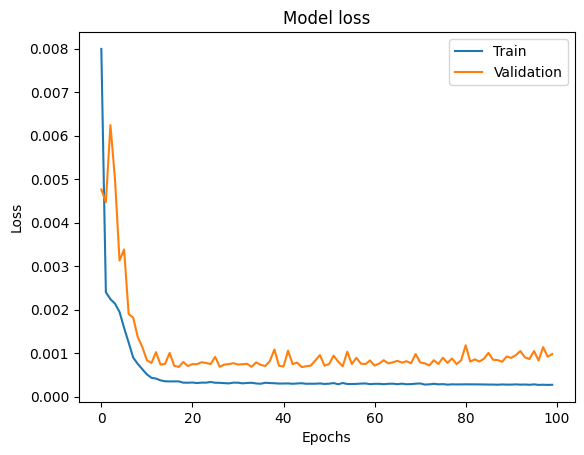

In [3]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=16, return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

64/64 [==============================] - 1s 1ms/step
RMSE: 6.148750719875557
MAPE: 3.374521495186912
MSE:  37.80713541517019
MSLE:  0.0021699665947833365
MAE:  4.5070086574754225
R-squared:  0.8586350004953403


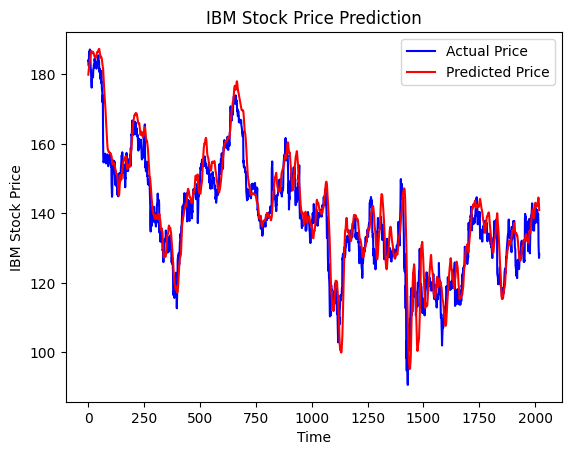

In [4]:
# Make predictions
y_pred = model.predict(X_test)

y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming y_pred and y_test are NumPy arrays
# Note: For MAPE, make sure y_test does not contain zeros to avoid division by zero.

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print('RMSE:', rmse)
print('MAPE:', mape)


print('MSE: ', mse)
print('MSLE: ', msle)
print('MAE: ', mae)
print('R-squared: ', r2)

# Plot the predictions vs the real data
plt.plot(y_test, color='blue', label='Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

# 1
RMSE: 3.4254854508410113  
MAPE: 1.8144602678363666  
MSE:  11.733950573923448  
MSLE:  0.0006569501219651215  
MAE:  2.4491094395626716  
R-squared:  0.9631499914253284  
 
# 1-3

RMSE: 6.078880969983048  
MAPE: 3.316567922817762  
MSE:  36.95279384722205  
MSLE:  0.002067308836169198  
MAE:  4.445746821684231  
R-squared:  0.8816022738103634  

# 1-3-9
RMSE: 9.681496370442565  
MAPE: 5.433762503375542  
MSE:  93.73137197089255  
MSLE:  0.005184730334292754  
MAE:  7.309876317143523  
R-squared:  0.6795390158852281  

# 1-5-20
RMSE: 12.73980415817289  
MAPE: 7.46507220205909  
MSE:  162.30260998859924  
MSLE:  0.008368224922447263  
MAE:  10.103675051213184  
R-squared:  0.3931328536613483  


